In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Blur image, Threshold

In [3]:
def mean_threshold(img, display=True):
    mean = np.mean(img)

    img[img >= mean] = 255
    img[img < mean] = 0

    if display:
        plt.figure(figsize = [10, 10])
        plt.axis('off')
        plt.imshow(img, cmap="gray")

    return img

In [4]:
def threshold(img, threshold=0.5):
    img[img >= threshold] = 1
    img[img < threshold] = 0

    return img
    

In [5]:
def clean_img(img_path):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    # clahe = cv2.createCLAHE(clipLimit=200.0, tileGridSize=(4,4))
    # img = clahe.apply(img)

    for _ in range(5):
        img = cv2.blur(img, (10, 10))
        mean_threshold(img)

    return img 

In [7]:
img = clean_img('../dataset/handwritten_operators/plus/plus 2.png')
plt.axis('off')
plt.imshow(img, cmap='gray')

[ WARN:0@7.149] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../dataset/handwritten_operators/plus/plus 2.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [8]:
def adaptive_clean(img_path):
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

    # Convert to grayscale and apply Otsu's binarization for noise reduction
    # https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(5,5),0)
    _, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #img = 255 - img
    return img


In [9]:
img = adaptive_clean('../dataset/handwritten_operators/plus/plus 2.png')
print(img.shape)
plt.axis('off')
plt.imshow(img, cmap='gray')

[ WARN:0@160.107] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../dataset/handwritten_operators/plus/plus 2.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'astype'

# Center the Image

In [ ]:
# img = cv2.imread('./Four_full (16).jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# h, w = img.shape[:2]
# new = np.zeros((h, w, 3), dtype=np.uint8)
# new[:, :, :] = img[:, :, :]

# plt.axis('off')
# plt.imshow(new)

In [ ]:
from math import ceil
# Center and square an image
def center_img(img):
    # Getting the contour
    # https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
    # contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    # print(hierarchy)
    # M = cv2.moments(contours[0])
    # cv2.drawContours(img, contours, -1, (0,255,0), 15)
    # cX = int(M["m10"] / M["m00"])
    # cY = int(M["m01"] / M["m00"])

    # tX, tY are translations from center of original image to center of character

    # T = np.float32([[1, 0, tX], [0, 1, tY]]) 
    
    # centered = cv2.warpAffine(img, T, (w, h)) 

    # Assuming the image is clean, choose the bounding box for the symbol
    bx, by, bw, bh = cv2.boundingRect(img)
    print(bx, by, bw, bh)

    dim = max(bw, bh) * 1.05 # width of canvas 
    x_tl, y_tl = dim / 1.05 * .025, dim / 1.05 * .025 # top left corner

    dim = int(dim)
    x_tl, y_tl = int(x_tl), int(y_tl)
    centered = np.zeros((dim, dim))
    
    for y in range(by, by + bh + 1):
        for x in range(bx, bx + bw + 1):
            centered[y - by + y_tl][x - bx + x_tl] = img[y][x]
            
    return centered

1050 1013 1261 1319


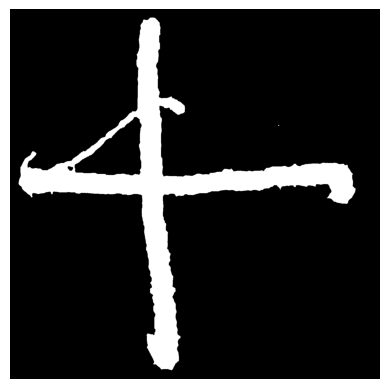

In [ ]:
centered = center_img(img)
plt.axis('off')
plt.imshow(centered, cmap='gray')

# Rescale the Image

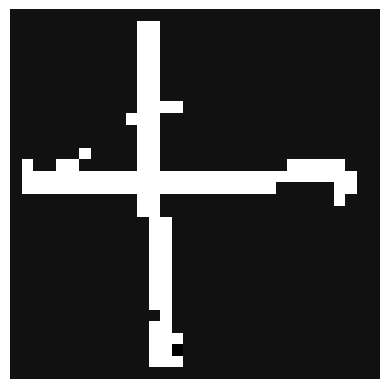

In [ ]:
# need similar padding for all images
# same center, scale, thickness

def resize_img(img):

    # resize = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
    # resize[resize > 0] = 255

    resize = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
    resize[resize > 0] = 255
    return resize

resized = resize_img(centered)
plt.axis('off')
plt.imshow(resized, cmap='gray')